# Applied Machine Learning---HW #3



### Group Member: YAO LI(YL3765), QINWEI ZHAO(QZ2307)

# Part 1 (Read dataset)

In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import power_transform
from sklearn.linear_model import RidgeCV,LassoCV, ElasticNetCV
from sklearn.feature_selection import VarianceThreshold

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor

In [85]:
train_filenames = ["2015.csv", "2016.csv", "2017.csv"]
train = pd.concat( [ pd.read_csv(f) for f in train_filenames ] )

test_filename = ["2018.csv"]
test = pd.concat( [ pd.read_csv(f) for f in test_filename ] )

In [86]:
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

In [87]:
train.shape

(3710, 160)

In [88]:
test.shape

(1223, 160)

In [89]:
y_train = train['Comb Unrd Adj FE - Conventional Fuel']
y_test = test['Comb Unrd Adj FE - Conventional Fuel']

# Part 2 (Drop Columns)

In [90]:
# drop train data contains 'FE'(except for the target),'CO2','EPA'
target = train['Comb Unrd Adj FE - Conventional Fuel'] 
#CO2 #7
train = train[train.columns.drop(list(train.filter(regex = 'CO2')))]
test = test[test.columns.drop(list(test.filter(regex = 'CO2')))]

#EPA #15
train = train[train.columns.drop(list(train.filter(regex = 'EPA')))]
test = test[test.columns.drop(list(test.filter(regex = 'EPA')))]


#FE #21
train = train[train.columns.drop(list(train.filter(regex = 'FE')))]
test = test[test.columns.drop(list(test.filter(regex = 'FE')))]


#MPG
train = train[train.columns.drop(list(train.filter(regex = 'MPG')))]
test = test[test.columns.drop(list(test.filter(regex = 'MPG')))]

#Guzzler
train = train[train.columns.drop(list(train.filter(regex = 'Guzzler')))]
test = test[test.columns.drop(list(test.filter(regex = 'Guzzler')))]

#Smog
train = train[train.columns.drop(list(train.filter(regex = 'Smog')))]
test = test[test.columns.drop(list(test.filter(regex = 'Smog')))]

In [91]:
train.shape,test.shape

((3710, 104), (1223, 104))

In [92]:
#add target into train dataset
train['Comb Unrd Adj FE - Conventional Fuel'] = y_train 

#add target into test dataset
test['Comb Unrd Adj FE - Conventional Fuel'] = y_test

train.shape, test.shape

((3710, 105), (1223, 105))

In [93]:
#drop rows with all nan values
train = train.dropna(axis = 0, how = 'all')
test = test.dropna(axis = 0, how = 'all')
train.shape, test.shape

((3701, 105), (1220, 105))

In [94]:
#check rows without target value ('Comb Unadj FE - Conventional Fuel')
train['Comb Unrd Adj FE - Conventional Fuel'].isnull().sum()
test['Comb Unrd Adj FE - Conventional Fuel'].isnull().sum()

0

In [95]:
#drop the features with 50% missing value
thresh_count_train = 0.5 * train.shape[0] 
train = train.dropna(axis = 1, thresh = thresh_count_train)

test = test[train.columns]
# thresh_count_test = 0.5 * test.shape[0] 
# test = test.dropna(axis = 1, thresh = thresh_count_test)
train.shape, test.shape

((3701, 48), (1220, 48))

In [96]:
#drop constant features(with only one value)
train = train.drop(['Fuel Unit - Conventional Fuel', 'Fuel Unit Desc - Conventional Fuel',
                    "Police/Emerg?", "Suppressed?"], axis = 1)

test = test.drop(['Fuel Unit - Conventional Fuel', 'Fuel Unit Desc - Conventional Fuel',
                    "Police/Emerg?", "Suppressed?"], axis = 1)

train.shape, test.shape

((3701, 44), (1220, 44))

# Part 3 (Impute)

In [103]:
pd.concat([train.apply(lambda x: sum(x.isnull())).rename("num_missing"),
          train.apply(lambda x: len(set(x))).rename("num_unique")],axis=1)

,num_missing,num_unique
# Cyl,0,8
# Gears,0,8
$ You Spend over 5 years (increased amount spent in fuel costs over 5 years - on label),1080,1123
Air Aspiration Method Desc,0,4
Annual Fuel1 Cost - Conventional Fuel,0,67
Calc Approach Desc,0,3
Camless Valvetrain (Y or N),0,2
Car/Truck Category - Cash for Clunkers Bill.,1242,4
Carline,0,1153
Carline Class,0,23


In [105]:
#impute both num and cate 
train = train.apply(lambda x:x.fillna(x.value_counts().index[0]))
test = test.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [106]:
train.shape,test.shape

((3701, 44), (1220, 44))

# Part 5 (EDVA)

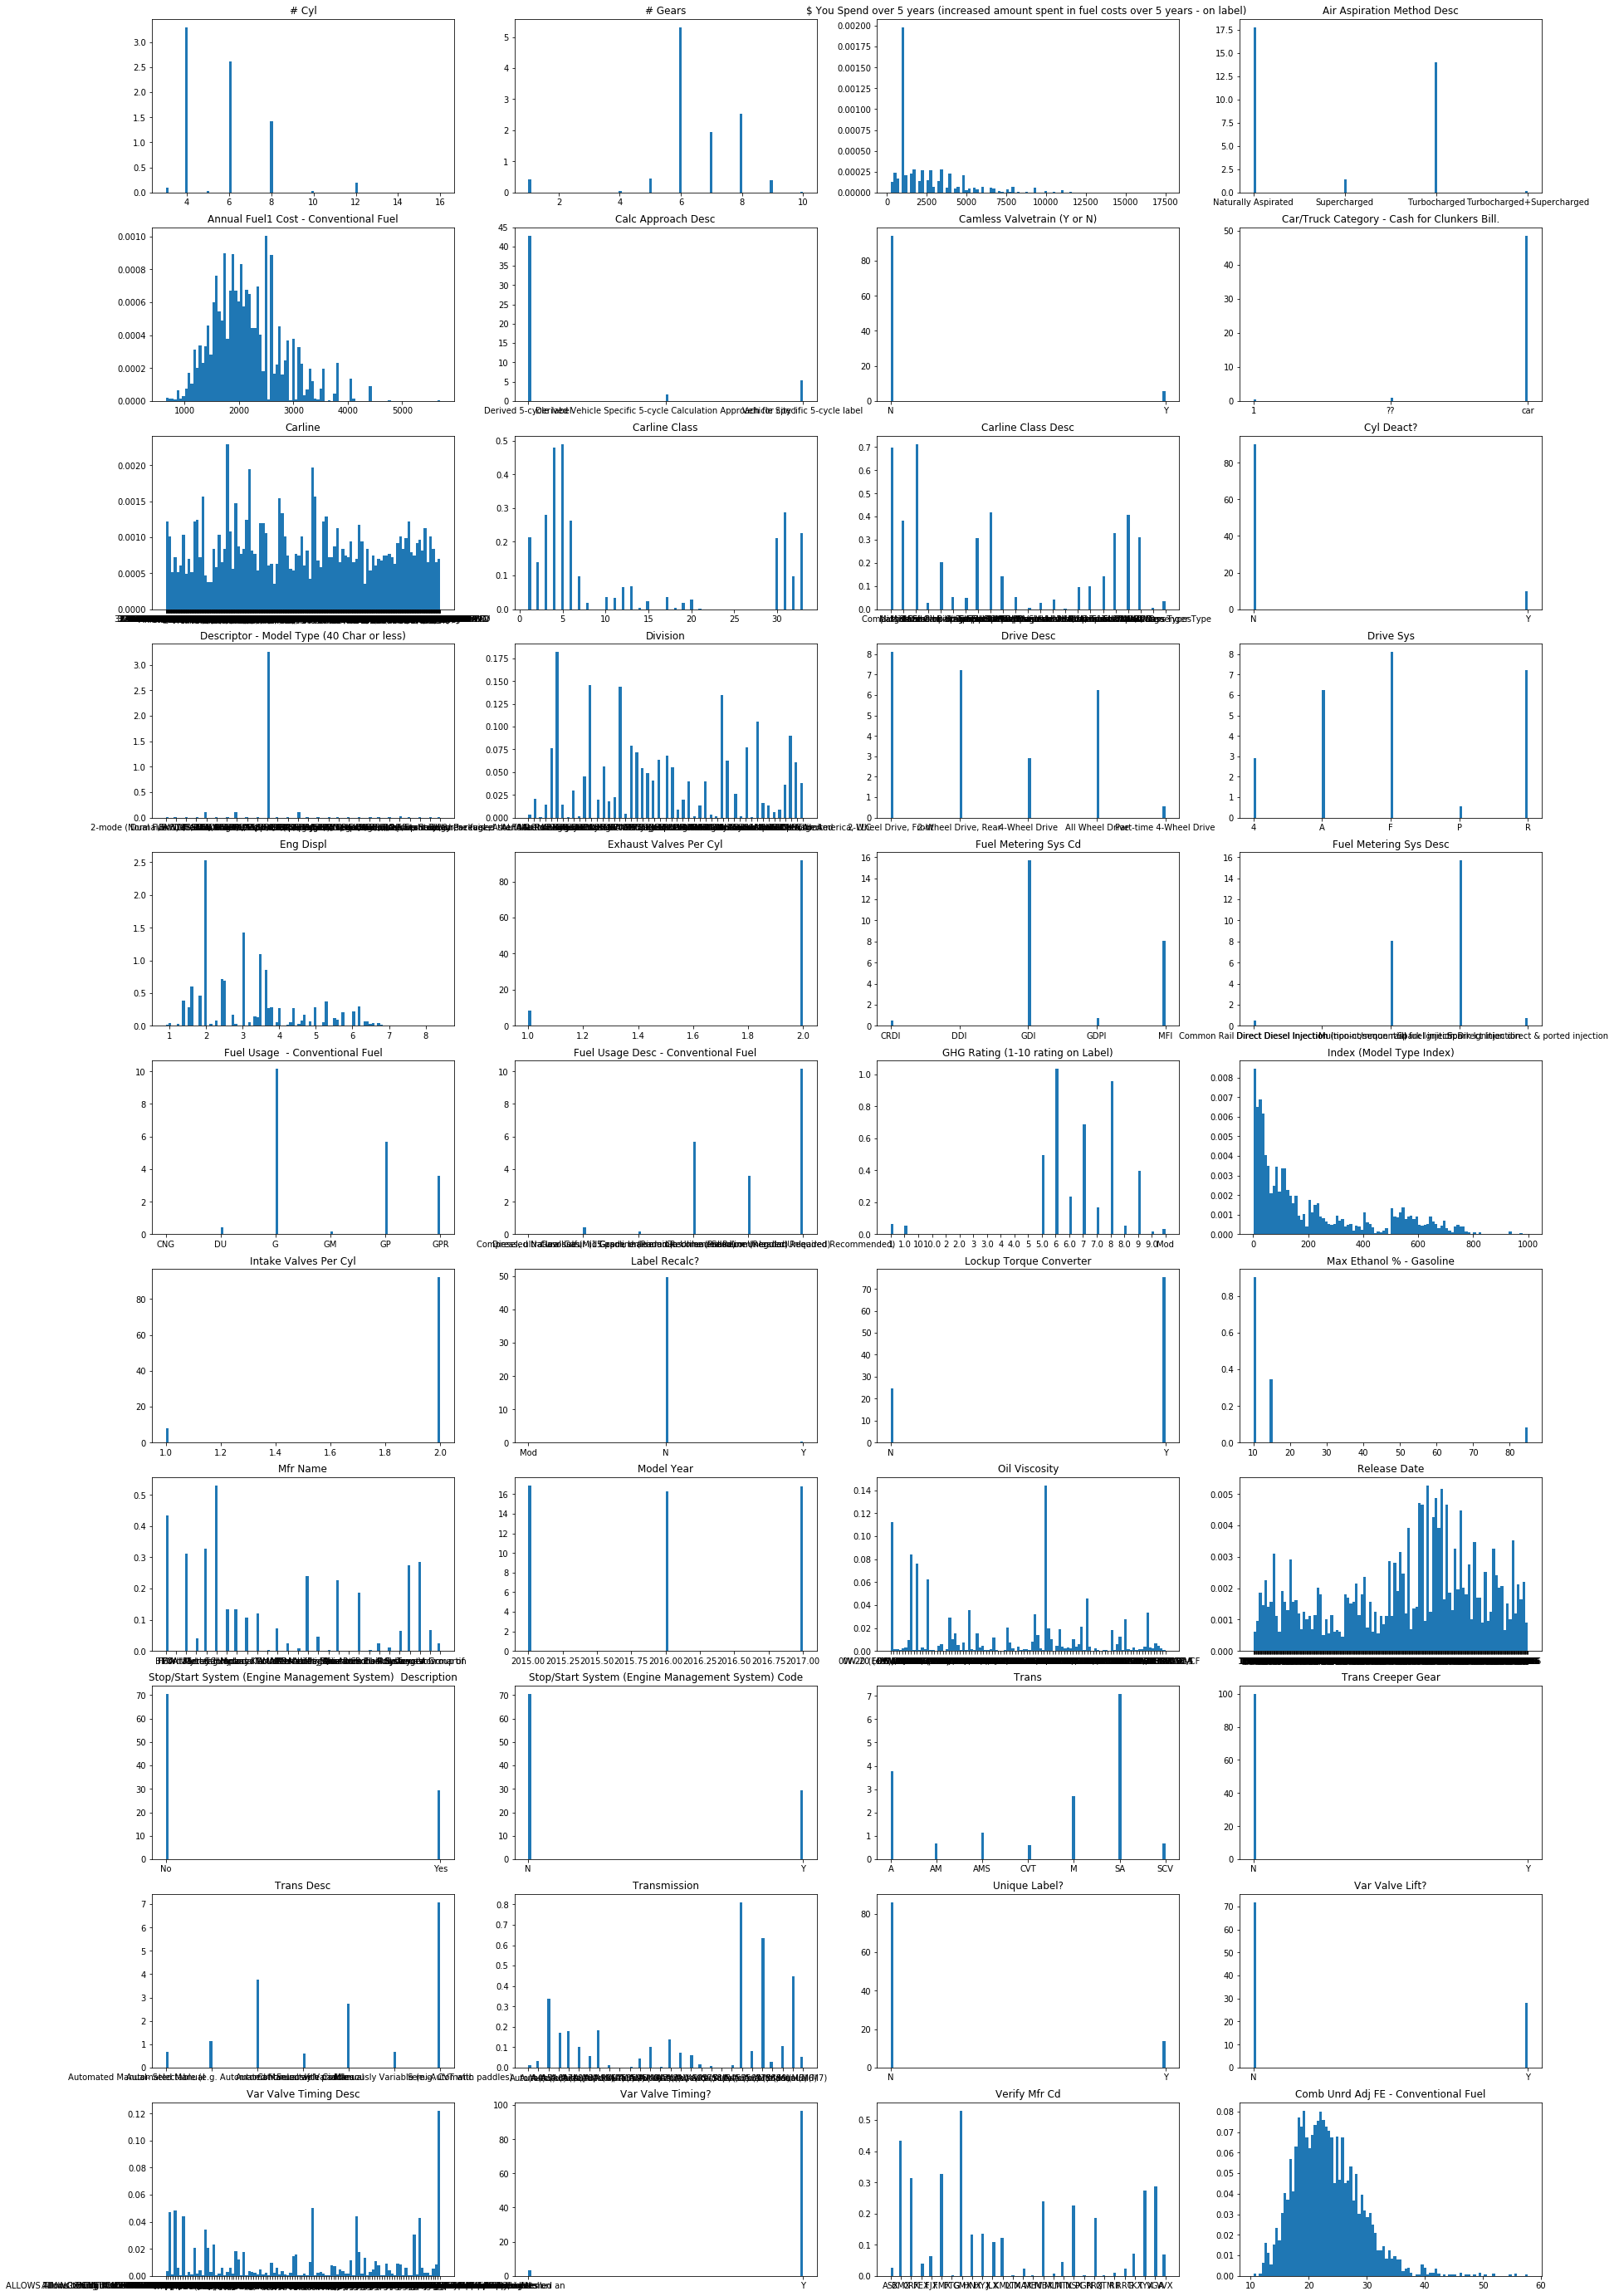

In [109]:
fig, ax = plt.subplots(11, 4, figsize = (30, 50)) 
for i in range(0,11):
    for j in range(0,4):
        ax[i][j].hist(train[train.columns[i*4+j]],density=True,bins = 100) 
        ax[i][j].set_title(train.columns[i*4+j])

plt.show()

# Part 6 (Encode)

In [110]:
train.dtypes

# Cyl                                                                                       float64
# Gears                                                                                     float64
$ You Spend over 5 years (increased amount spent in fuel costs over 5 years - on label)     float64
Air Aspiration Method Desc                                                                   object
Annual Fuel1 Cost - Conventional Fuel                                                       float64
Calc Approach Desc                                                                           object
Camless Valvetrain (Y or N)                                                                  object
Car/Truck Category - Cash for Clunkers Bill.                                                 object
Carline                                                                                      object
Carline Class                                                                               float64


In [111]:
cate_vars = ['Air Aspiration Method Desc',
 'Calc Approach Desc',
 'Camless Valvetrain (Y or N)',
 'Car/Truck Category - Cash for Clunkers Bill.',
 'Carline',
 'Carline Class Desc',
 'Cyl Deact?',
 'Descriptor - Model Type (40 Char or less)',
 'Division',
 'Drive Desc',
 'Drive Sys',
 'Fuel Metering Sys Cd',
 'Fuel Metering Sys Desc',
 'Fuel Usage  - Conventional Fuel',
 'Fuel Usage Desc - Conventional Fuel',
 'GHG Rating (1-10 rating on Label)',
 'Label Recalc?',
 'Lockup Torque Converter',
 'Mfr Name',
 'Oil Viscosity',
 'Release Date',
 'Stop/Start System (Engine Management System)  Description',
 'Stop/Start System (Engine Management System) Code',
 'Trans',
 'Trans Creeper Gear',
 'Trans Desc',
 'Transmission',
 'Unique Label?',
 'Var Valve Lift?',
 'Var Valve Timing Desc',
 'Var Valve Timing?',
 'Verify Mfr Cd']

num_vars = [x for x in train.columns if x not in cate_vars + ['Comb Unrd Adj FE - Conventional Fuel']]

In [116]:
#train to dummy
train_dummies = pd.get_dummies(train,columns = cate_vars)
train_dummies.shape

(3701, 2199)

In [117]:
#test to dummy
test_dummies = pd.get_dummies(test,columns = cate_vars)
test_dummies.shape

(1220, 1378)

In [119]:
#make train and test at the same size
diff_cols = set(train_dummies.columns)-set(test_dummies.columns)
for col in diff_cols:
    train_dummies.drop([col],axis=1,inplace=True)

In [120]:
diff_cols = set(test_dummies.columns)-set(train_dummies.columns)
for col in diff_cols:
    test_dummies.drop([col],axis=1,inplace=True)

In [121]:
test_dummies.shape,train_dummies.shape

((1220, 1071), (3701, 1071))

# Part 7 (Standardize)

In [123]:
#standardize all num variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_dummies[num_vars] = scaler.fit_transform(train_dummies[num_vars])
test_dummies[num_vars] = scaler.transform(test_dummies[num_vars])

In [124]:
train_dummies.shape, test_dummies.shape

((3701, 1071), (1220, 1071))

# Part 8 (Feature Selection)

In [125]:
train_copy = train_dummies.copy()
test_copy = test_dummies.copy()

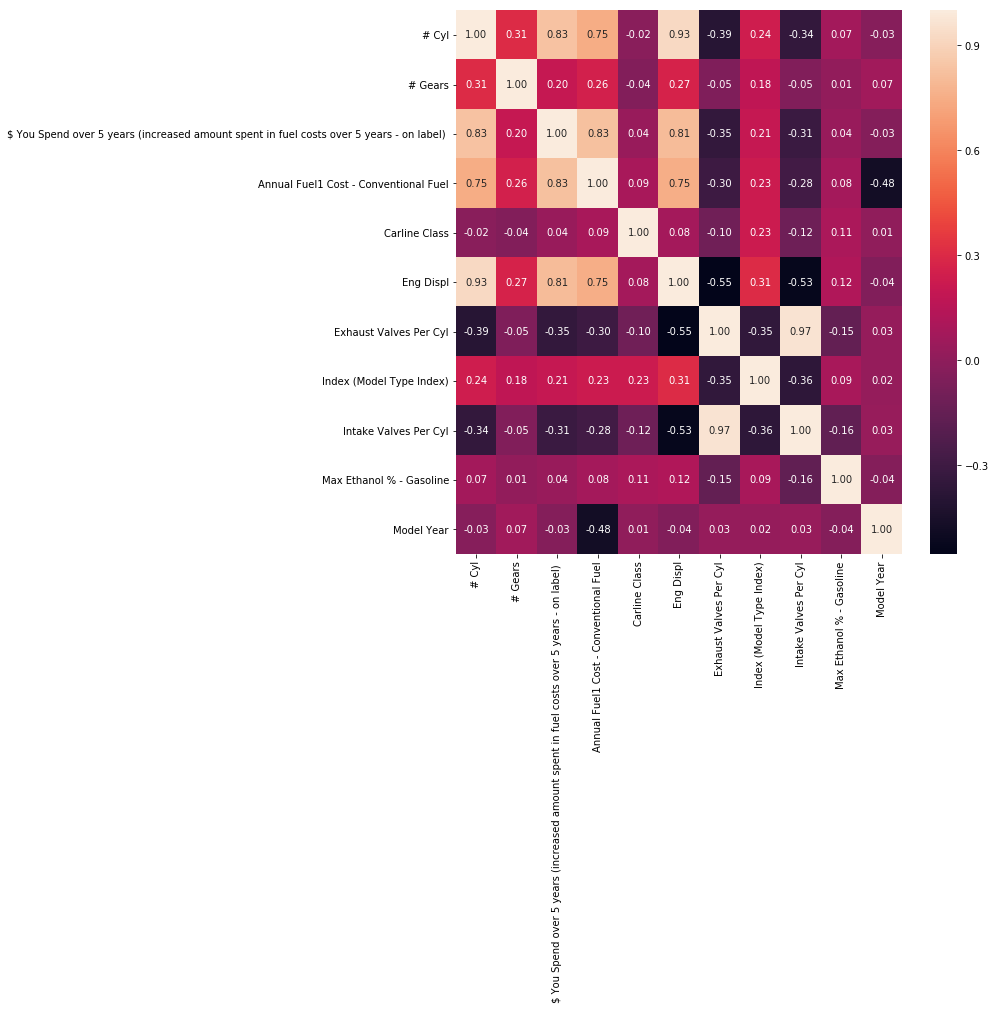

In [126]:
plt.figure(figsize=(10,10))
sns.heatmap(train_copy[num_vars].corr(), annot=True, fmt=".2f")
plt.show()

#### drop variables with high correlation (corr >0.9)
#### cyl - Eng Displ (0.93), drop Eng Displ
#### Exhaust value per cyl - intake values per cyl (0.97), drop Exhaust value per cyl

In [127]:
train_copy.drop(['Eng Displ','Exhaust Valves Per Cyl'],axis=1,inplace=True)
test_copy.drop(['Eng Displ','Exhaust Valves Per Cyl'],axis=1,inplace=True)

In [128]:
y_train = train_copy['Comb Unrd Adj FE - Conventional Fuel']
X_train = train_copy.drop('Comb Unrd Adj FE - Conventional Fuel', axis = 1)
X_train.shape, y_train.shape

((3701, 1068), (3701,))

In [129]:
y_test = test_copy['Comb Unrd Adj FE - Conventional Fuel']
X_test = test_copy.drop('Comb Unrd Adj FE - Conventional Fuel', axis = 1)
X_test.shape, y_test.shape

((1220, 1068), (1220,))

# Part 9 (Linear model - Ridge)

In [130]:
Ridge_train_score = np.mean(cross_val_score(Ridge(), X_train, y_train, cv=10))

In [131]:
Ridge_train_score

0.96280016500708254

In [49]:
pipe_ridge_po = make_pipeline(PolynomialFeatures(include_bias = False), Ridge())
pipe_ridge.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [50]:
pipe_ridge_po.score(X_test, y_test)

0.69124022388402828

In [134]:
pipe_ridge = make_pipeline(PolynomialFeatures(interaction_only=True), VarianceThreshold(), RidgeCV())
pipe_ridge.fit(X_train, y_train).score(X_test, y_test)

0.82447705869854837

In [52]:
np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv=10))

-2.6650864242712089e+19

In [53]:
np.mean(cross_val_score(Lasso(), X_train, y_train, cv=10))

0.60527381112998169

In [54]:
np.mean(cross_val_score(ElasticNet(), X_train, y_train, cv=10))

0.63454836905928569

In [55]:
#Tune parameters
# R_param_grid = {'alpha': np.logspace(-3, 3, 15)}
# R_grid = GridSearchCV(Ridge(), R_param_grid)
# R_grid.fit(X_train, y_train)
# R_grid.best_params_, R_grid.best_score_
ridge = RidgeCV().fit(X_train, y_train)
print ("ridgecv score : {:.2f}".format(ridge.score(X_test, y_test)))
print ("ridgecv alpha : {}".format(ridge.alpha_))

ridgecv score : 0.55
ridgecv alpha : 1.0


In [56]:
lasso = LassoCV().fit(X_train, y_train)
print ("Lassocv score : {:.2f}".format(lasso.score(X_test, y_test)))
print ("Lassocv alpha : {}".format(lasso.alpha_))

Lassocv score : 0.45
Lassocv alpha : 0.004608101351222647


In [57]:
elasticNet = ElasticNetCV().fit(X_train, y_train)
print ("elasticNet score : {:.2f}".format(elasticNet.score(X_test, y_test)))
print ("elasticNet alpha : {}".format(elasticNet.alpha_))

elasticNet score : 0.59
elasticNet alpha : 0.009216202702445294


# Part 10 (Other models -SVM)

In [60]:
np.mean(cross_val_score(SVR(), X_train, y_train, cv=10))

0.76267766773898837

In [61]:
svr = SVR().fit(X_train, y_train)
svr.score(X_test, y_test)

0.64519226002249885

In [64]:
param_grid_svr = {'C': np.logspace(-3, 2, 6),
              'gamma': np.logspace(-3, 2, 6) / X_train.shape[0]}

In [65]:
grid_svr = GridSearchCV(SVR(), param_grid=param_grid_svr, cv=10)
grid_svr.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02]), 'gamma': array([  2.70197e-07,   2.70197e-06,   2.70197e-05,   2.70197e-04,
         2.70197e-03,   2.70197e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [69]:
pred_svr = grid_svr.predict(X_test)

In [67]:
grid_svr.score(X_test, y_test)

0.75942516121681747

In [152]:
pipe_svr_po.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'svr', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'svr__C', 'svr__cache_size', 'svr__coef0', 'svr__degree', 'svr__epsilon', 'svr__gamma', 'svr__kernel', 'svr__max_iter', 'svr__shrinking', 'svr__tol', 'svr__verbose'])

In [153]:
param_grid_svr_po = {'svr__C': np.logspace(-3, 2, 6),
              'svr__gamma': np.logspace(-3, 2, 6) / X_train.shape[0]}

In [ ]:
pipe_svr_po = make_pipeline(PolynomialFeatures(interaction_only=True), SVR())
grid_pipe_svr = GridSearchCV(pipe_svr_po, param_grid = param_grid_svr_po, cv=5)
grid_pipe_svr.fit(X_train, y_train).score(X_test, y_test)